# PyTorch Machine Learning Basics

>**Credits:** 
>The coding examples are taken from the PyTorch course from [Daniel Bourke](https://github.com/mrdbourke) - https://www.mrdbourke.com
>
>The course resources:
>* YT: https://www.youtube.com/watch?v=V_xro1bcAuA
>* Git: https://github.com/mrdbourke/pytorch-deep-learning/
>* Jupyter Documentation: https://www.learnpytorch.io


Programming was done on an Apple Silicon, hence using Apple MPS as device.

For Cuda GPU, additional packages must be installed - see https://pypi.org/project/torch/#installation


## 01 Prepare environment and install packages


Using Python 3.11 as it is more compatible at the moment (Feb 2023).

Required packages:
* torch
* torchinfo
* torchmetrics
* matplotlib
* scikit-learn



In [1]:
#!pip install -U torch torchinfo torchmetrics matplotlib scikit-learn

In [2]:
# Check installation
import torch
from torch import nn
import matplotlib.pyplot as plt

print(f"Torch Version: {torch.__version__}")

Torch Version: 2.2.0


## 02 Prepare Tensor Device

Pytorch uses different devices to run the computation, we will use following order:
1. MPS Metal Performance Shader (MPS) for Apple Silicon Chips
2. CPU as backup device

GPU (cuda) is not part of this Notebook, due to missing development device at the moment.

**_Hint_:**
* Tensors are created by default on the device "cpu" and can be overidden by `torch.set_default_device(device)`
* For some operations it might be needed to shift the Tensor back to cpu, by using `torch.Tensor.to(torch.device("cpu"))`

<br/><br/>

### 02.01 Set MPS device

PyTorch implements Metal Perfromance Shader (MPS) for more performance on Apple Silicon chips: https://pytorch.org/docs/stable/notes/mps.html

MPS is best used for training extremly large models where overhead of 25-110us is acceptable - https://github.com/pytorch/pytorch/issues/77799#issuecomment-1305775134https://github.com/pytorch/pytorch/issues/77799#issuecomment-1305775134

Otherwise it might slow down

In [3]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ and/or you do not have an MPS-enabled device on this machine.")
    device = torch.device("cpu")
else:
    device = torch.device("mps")

# Check torch.device
print(f"device: {device}")

device: mps


## 03 Deep Learning Steps
Credits to: mrdbourke - https://www.learnpytorch.io/01_pytorch_workflow/

1. Getting Data ready
2. Build or pick a pre-trained model
    1. Build a loss function & optimizer
    2. Build a training loop
3. Fit the model to the data and make a prediction
4. Evaluate the model
5. Improve through experimentation
6. Save and reload your trained model

## 04 Preparations

This is the first step in the tutorial from Daniel Bourke - see https://www.learnpytorch.io/01_pytorch_workflow/

### 04.01 Prepare a Plot Function

For visualization of Data, it is handy to have a function ready.

In [4]:
def plot_data(train_data, 
              train_labels, 
              test_data, 
              test_labels, 
              predictions=None):
  """
  Plots training data, test data and compares predictions.
  All Tensors are moved to CPU device for convenience
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data.cpu(), train_labels.cpu(), c="b", s=2, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data.cpu(), test_labels.cpu(), c="orange", s=2, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data.cpu(), predictions.cpu(), c="r", s=2, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

### 04.02 Create Training and Test Data

Creating a data set with known parameters (weight and bias) which our model should learn.

This is a straight line which you can see by the formula `y = weight * X + bias` (linear regression)

It has only 1 Feature (`X` as input) and 1 label (`y` as output).

In [5]:
# Create weight and bias
weight = 0.2
bias = -0.05

# Create range values - start 0 & end 1 in 0.02 steps = 50 Datapoints
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 

# Print 10 Samples each
print("X:", X[:10])
print("y:", y[:10])

X: tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])
y: tensor([[-0.0500],
        [-0.0460],
        [-0.0420],
        [-0.0380],
        [-0.0340],
        [-0.0300],
        [-0.0260],
        [-0.0220],
        [-0.0180],
        [-0.0140]])


In [6]:
# Split data into 80% training and 20% test data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# Check the split
print(f"X (Training/Test): {len(X_train)}/{len(X_test)}")
print(f"y (Training/Test): {len(y_train)}/{len(y_test)}")

X (Training/Test): 40/10
y (Training/Test): 40/10


### 04.03 Plot data

Using previous defined function to visualize training and test data.

Expectation: Linear line

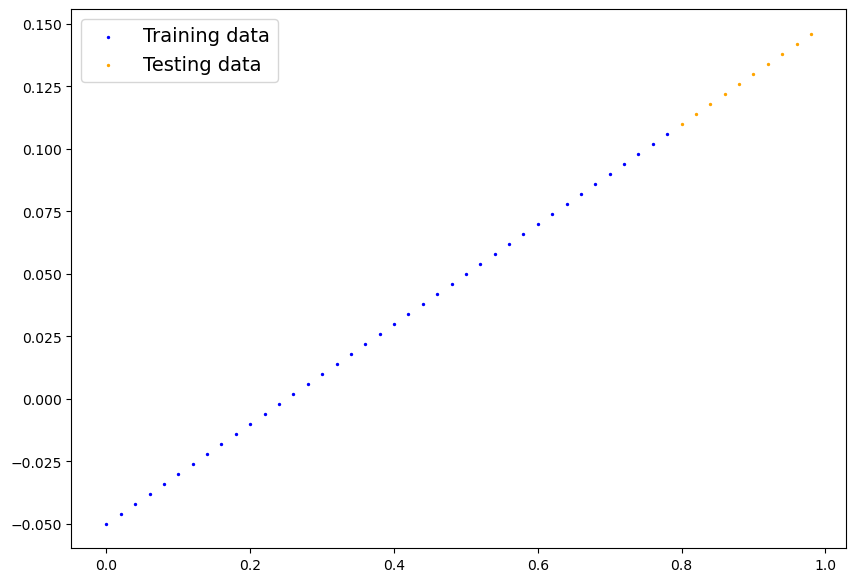

In [7]:
plot_data(X_train, y_train, X_test, y_test)

## 05 Create a Model

Create a new model by inheriting the `nn.Module` class.

The constructor initializes the super class and sets weights and bias' to random values.

To complete the model, a `forward` function must be defined for computing the propagation thru the neural network's layers (forward pass) - in our case only 1 Layer.

This class was taken from learnpytorch notebook, but the device has been added to generate the tensors.





In [8]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self, device=None):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float, # <- PyTorch loves float32 by default
                                                device=device), # <- added the device for the tensor
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float,# <- PyTorch loves float32 by default
                                            device=device), # <- added the device for the tensor
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)
    
    
# Set the manual seed when creating the model (this isn't always needed but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)

# Initializing the model without the device parameter for now
model_0 = LinearRegressionModel()

# Print Model and state_dict - default device should be shown for the tensors
model_0, model_0.state_dict()

(LinearRegressionModel(),
 OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))]))

In [9]:
# Check the Device of the first parameter
print(f"Before: {next(model_0.parameters()).device}")

# Set model to MPS (or whatever the device variable is pointing to)
model_0.to(device)

# Check the device after setting the model to the device
print(f"After: {next(model_0.parameters()).device}")

list(model_0.parameters())

Before: cpu
After: mps:0


[Parameter containing:
 tensor([0.3367], device='mps:0', requires_grad=True),
 Parameter containing:
 tensor([0.1288], device='mps:0', requires_grad=True)]

In [10]:
# Make the first predictions with model & test data
# Note: Our Model runs on MPS from before, so our Test Data must be on the same device
with torch.inference_mode(): 
    y_preds = model_0(X_test.to(device))

# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], device='mps:0')


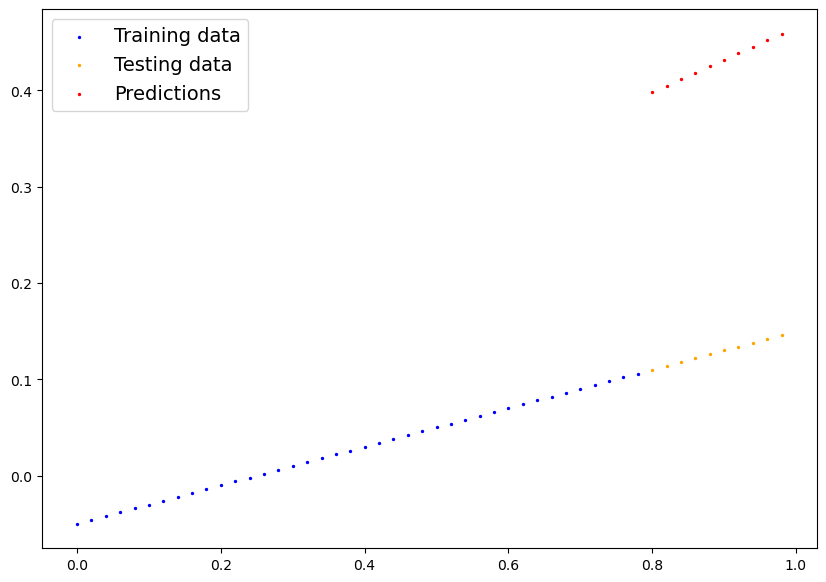

In [11]:
# Plot the predictions
plot_data(X_train, y_train, X_test, y_test, predictions=y_preds)

## 06 Train the model

For training following steps are needed:
1. Create a loss function - tells the model how far off it is
2. Create an optimizer function - tells the model how to update the internal parameters
3. Run a Training loop
    * Forward pass (Model goes thru all the of the training data once, performing `forward()` function calulations) - `model(X_train)`
    * Calculate the loss - `loss = loss_fn(y_pred, y_train)`
    * Zero gradients (Optimizers gradients are accumulated by default) - `optimizer.zero_grad()`
    * Perform backpropagation on the loss - `loss.backward()`
    * Update the optimizer (gradient descent) - `optimizer.step()`
4. Run a Testing loop
    * Forward pass with test data - `model(X_test)`
    * Calculate the loss with test data - `loss = loss_fn(y_pred, y_test)`
    * Calculate evaluation matrix (optional)

In [12]:
# 1. Create loss function - L1Loss = Mean Absolute Error
loss_fn = nn.L1Loss()

# 2. Create optimizer - SGD = Stochastic gradient descent
optimizer = torch.optim.SGD(params=model_0.parameters(), # optimize newly created model's parameters
                            lr=0.01)

In [13]:
# Preeseeding number generator
torch.manual_seed(42)

# Set the number of epochs
epochs = 100 


# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []


# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### 3. Training Loop
    model_0.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### 4. Testing
    model_0.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.cpu().detach().numpy())
        test_loss_values.append(test_loss.cpu().detach().numpy())
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.2321186512708664 | Test loss: 0.2869928479194641
Epoch: 10 | Train loss: 0.11690870672464371 | Test loss: 0.1522829383611679
Epoch: 20 | Train loss: 0.012798932380974293 | Test loss: 0.030703285709023476
Epoch: 30 | Train loss: 0.007887219078838825 | Test loss: 0.01770268939435482
Epoch: 40 | Train loss: 0.004448419902473688 | Test loss: 0.009430295787751675
Epoch: 50 | Train loss: 0.007900259457528591 | Test loss: 0.007865997031331062
Epoch: 60 | Train loss: 0.007900259457528591 | Test loss: 0.007865997031331062
Epoch: 70 | Train loss: 0.007900259457528591 | Test loss: 0.007865997031331062
Epoch: 80 | Train loss: 0.007900259457528591 | Test loss: 0.007865997031331062
Epoch: 90 | Train loss: 0.007900259457528591 | Test loss: 0.007865997031331062


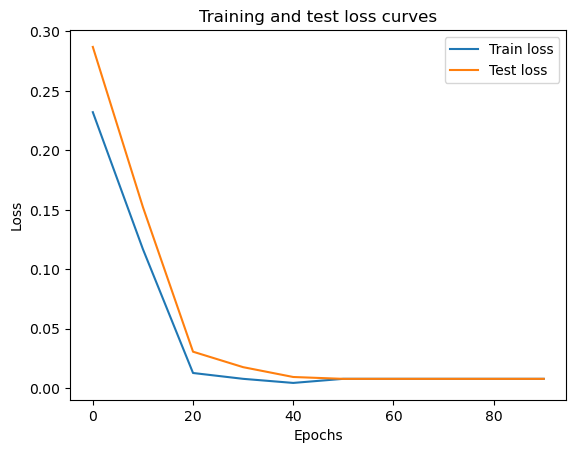

In [16]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

## 07 Show Learned Parameters

In [18]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.2046], device='mps:0')),
             ('bias', tensor([-0.0597], device='mps:0'))])

And the original values for weights and bias are:
weights: 0.2, bias: -0.05


## 08 Use the Model

In [19]:
# Turn model into evaluation mode
model_0.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.1040],
        [0.1081],
        [0.1122],
        [0.1163],
        [0.1203],
        [0.1244],
        [0.1285],
        [0.1326],
        [0.1367],
        [0.1408]], device='mps:0')

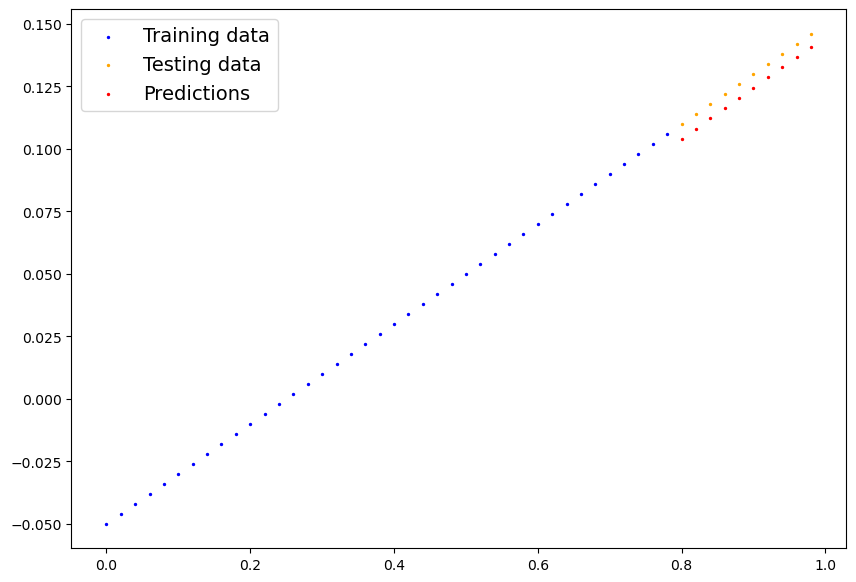

In [20]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU
plot_data(X_train, y_train, X_test, y_test, y_preds)

## 08 Saving and Loading the Model

Saving the model is done via `torch.save()` function and loading via `torch.load()`
<br/><br/>

The recommended way is to store only the state_dict of the model with the extension `.pt` or `.pth`.

Therefore `torch.load_state_dict()` function must be used
<br/><br/>

Remember to set the model into evaluation mode with `model.eval()` function, before running inference.

More information including checkpoint saving: https://pytorch.org/tutorials/beginner/saving_loading_models.html


In [22]:
# Save State Dict from our model
model_filename = "./linear_regression_state.pt"
torch.save(model_0.state_dict(),"./linear_regression_state.pt")

In [23]:
# Create new Model from defined class above and load parameters
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(model_filename))


<All keys matched successfully>

In [28]:
loaded_model.to(device)

# 1. Put the loaded model into evaluation mode
loaded_model.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)

In [30]:
# Compare all predictions with previous predictions
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')